# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 12.10.2024

Мягкий дедлайн: 23:59MSK 27.10.2024

Жесткий дедлайн: 23:59MSK 31.10.2024

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [folium]2m2/3 [folium]


In [111]:
import folium

m = folium.Map(location=(50.97178, 9.79418), zoom_start=15)

m

Если вы всё сделали правильно, то выше должна открыться карта

### 📌 **Памятка по дз2**

Обрабатывать данные можно любым способом (`polars`, `pandas`, `pyspark`, ...), который вам нравится и запускается в ноутбуке, и любой библиотекой для визуализации (`matplotlib`, `seaborn`, `plotly`, ...). Пользуйтесь на здоровье, но!

> Учтите, что `polars` всё ещё молодой и не все библиотеки его поддерживают. `sklearn` во многом уже работает, но на всякий случай не стесняйтесь пользоваться методами `pl.DataFrame.to_pandas()` или `pl.DataFrame.to_numpy()`    

> Впрочем, `pandas` тоже не лишён проблем. `sklearn` принимает `pd.DataFrame` почти везде, проблемы очень редки, но если вдруг возникнет какая-то беда с шейпами, или ещё какой-нибудь казус, а вы уверены, что всё правильно, пользуйтесь `pd.DataFrame.to_numpy()`. Это не всегда решает проблему, но часто помогает понять, что на самом деле не так. При желании можно передавать и `Iterable`, и sparse-матрицы

> Графики должны быть понятные, читаемые и пр. Консультируйтесь с памяткой из дз1 в задании на график

> Для воспроизводимости результатов не забывайте пользоваться `np.random.seed(...)`, при необходимости чистите мусор `gc.collect()`, лучше в каждой ячейке

> Все результаты должны быть получены в ноутбуке. На каждый **Вопрос** долен быть дан **Ответ** (письменно (в Markdown например) или кодом)

In [112]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as pl

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [113]:
train_data = pd.read_csv('train.csv')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [114]:
train_data.drop('dropoff_datetime', axis=1, inplace=True)
train_data["pickup_datetime"] = pd.to_datetime(train_data["pickup_datetime"])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

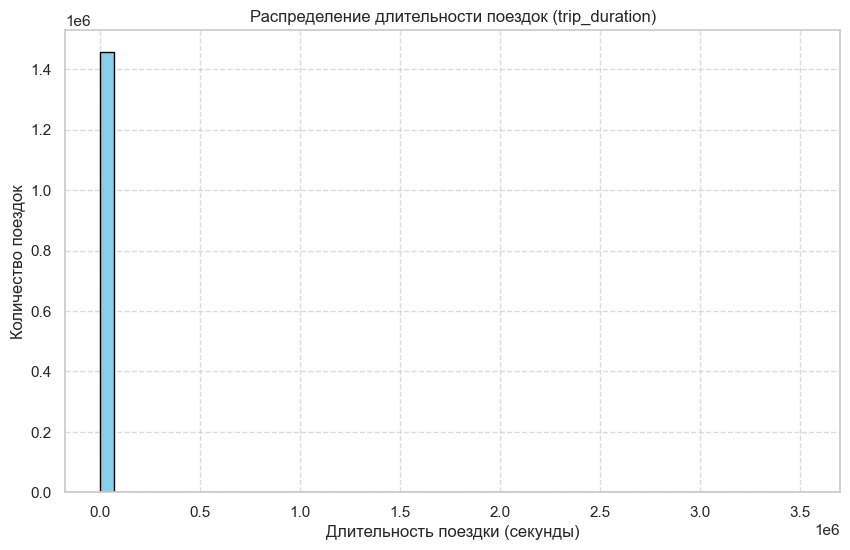

In [115]:
plt.figure(figsize=(10, 6))
plt.hist(train_data['trip_duration'], bins=50, color='skyblue', edgecolor='black')
plt.title('Распределение длительности поездок (trip_duration)')
plt.xlabel('Длительность поездки (секунды)')
plt.ylabel('Количество поездок')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

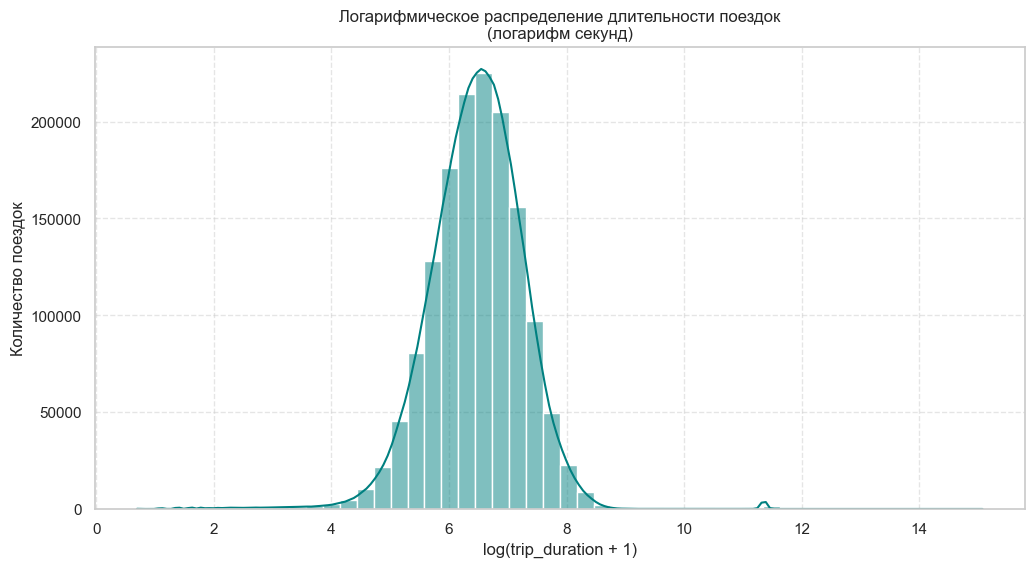

In [116]:
import numpy as np

plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(train_data['trip_duration']), bins=50, kde=True, color='teal')
plt.title('Логарифмическое распределение длительности поездок\n(логарифм секунд)')
plt.xlabel('log(trip_duration + 1)')
plt.ylabel('Количество поездок')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ**: График на обычной шкале выявил явный выброс, поэтому пришлось посмотреть на распределение логарифма, и да, видим, что присутствуют выбросы, в которых длина поездки составляла около 15 часов, что очевидно мало вероятно в реальности и больше походи на ошибку измерений счетчика - не выключился или что-то подобное. И видим на графике нормальное распределение, следовательно распределение таргета - логнормальное, а значит тяжелые хвосты вправо - поездки зачастую были длинными и составляли больше часа, что логично (например поездки в аэропорт)

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: RMSE - сочетает в себе преимущества MSE (дифференцируемость и способность отследить близость к оптимуму) и сохранение единиц измерений таргета в значениях ошибки. RMSLE - считает RMSE значений логарифмов. Здесь мы используем RMSLE, так как данные обладают логнормальныи распределением и используя обычное RMSE, мы бы подстраивались под тяжелые хвосты справа. А в RMSLE можем лучше оценить значения всех категорий поездок (длинных, коротких и т.д.)

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: 
RMSLE для модели $a$:\
$\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$ =
$\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \log{(\exp(\hat{a}(x_i)) - 1 + 1)}\big)^2}$ =
$\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}(x_i)\big)^2}$ \
Получилась RMSE для модели $\hat{a}$, оптимизация которой эквивалентна оптимизации MSE, так как квадратный корень - монотонно возрастающая функция



Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [117]:
train_data["log_trip_duration"] = np.log1p(train_data["trip_duration"])

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [118]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.mean((log1p_y_true - log1p_y_pred)**2)**0.5
rmsle_best_const = rmsle((np.full(len(train_data),np.mean(train_data["log_trip_duration"]))), train_data["log_trip_duration"])
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году:

/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_56556/2433305836.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


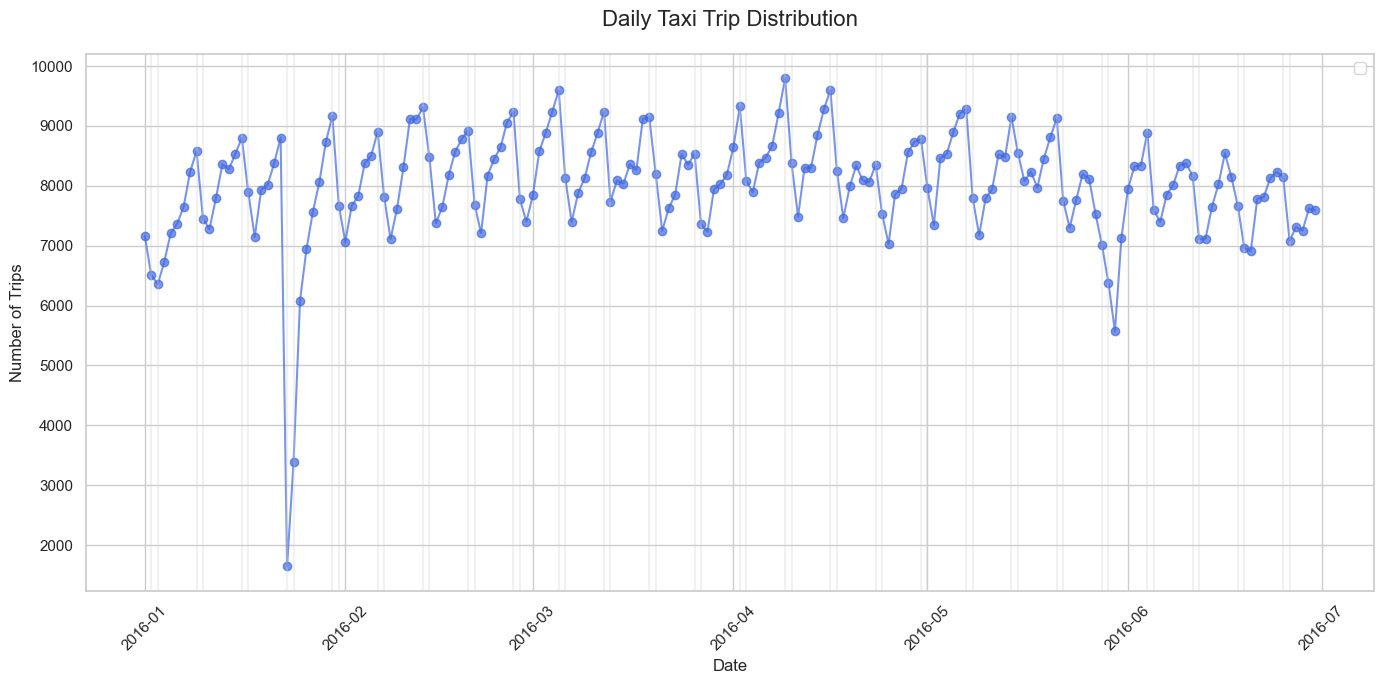

In [119]:
df = train_data.copy()
df['pickup_date'] = pd.to_datetime(train_data['pickup_datetime']).dt.date

daily_trips = df['pickup_date'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")
plt.plot(daily_trips.index, daily_trips.values, 
         marker='o', linestyle='-', color='royalblue', alpha=0.7)

plt.title('Daily Taxi Trip Distribution', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

for i, date in enumerate(daily_trips.index):
    if date.weekday() >= 5:
        plt.axvline(x=date, color='lightgray', alpha=0.3, linestyle='-')

plt.tight_layout()
plt.show()

In [120]:
daily_trips[daily_trips<6000]

pickup_date
2016-01-23    1648
2016-01-24    3383
2016-05-30    5570
Name: count, dtype: int64

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

**Ответ**: \
23го января была серьезная снежная буря, в связи с которой многие дороги были перекрыты \
30го мая ежегодно празднуется Memorial Day, в связи с чем также перекрывается большинство дорог в городе.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках:

/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_56556/2412925613.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_names, y=rides_by_day.values, palette='viridis')


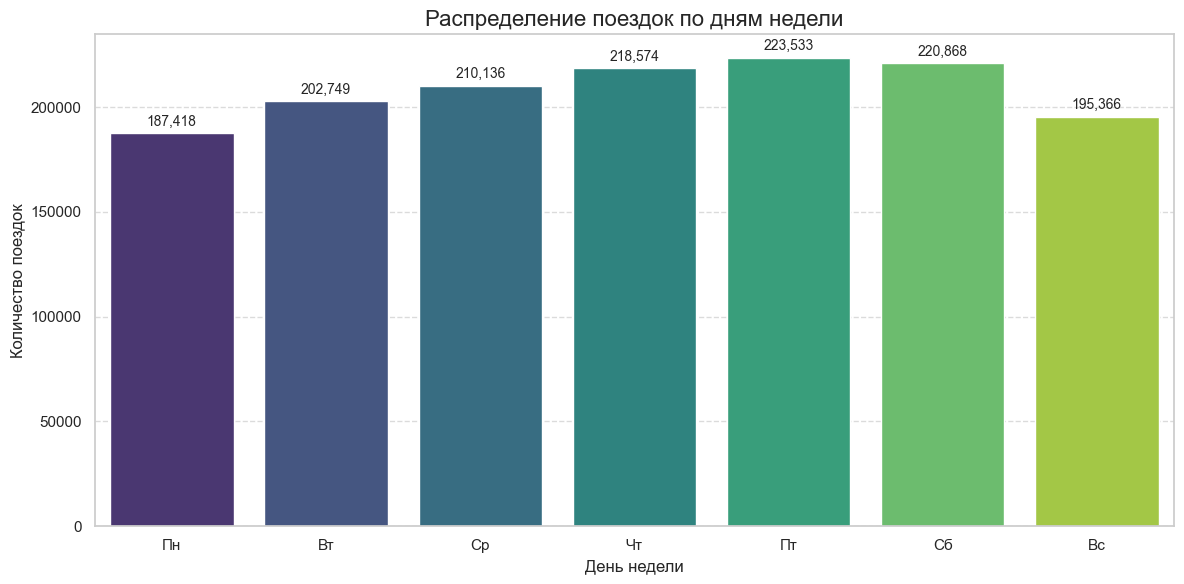

In [121]:
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
rides_by_day = df['day_of_week'].value_counts().sort_index()
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
plt.figure(figsize=(12, 6))
sns.barplot(x=day_names, y=rides_by_day.values, palette='viridis')

plt.title('Распределение поездок по дням недели', fontsize=16)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(rides_by_day.values):
    plt.text(i, value + 0.01*max(rides_by_day), f'{value:,}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_56556/1688583519.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hours, y=rides_by_hour.values, palette='viridis')


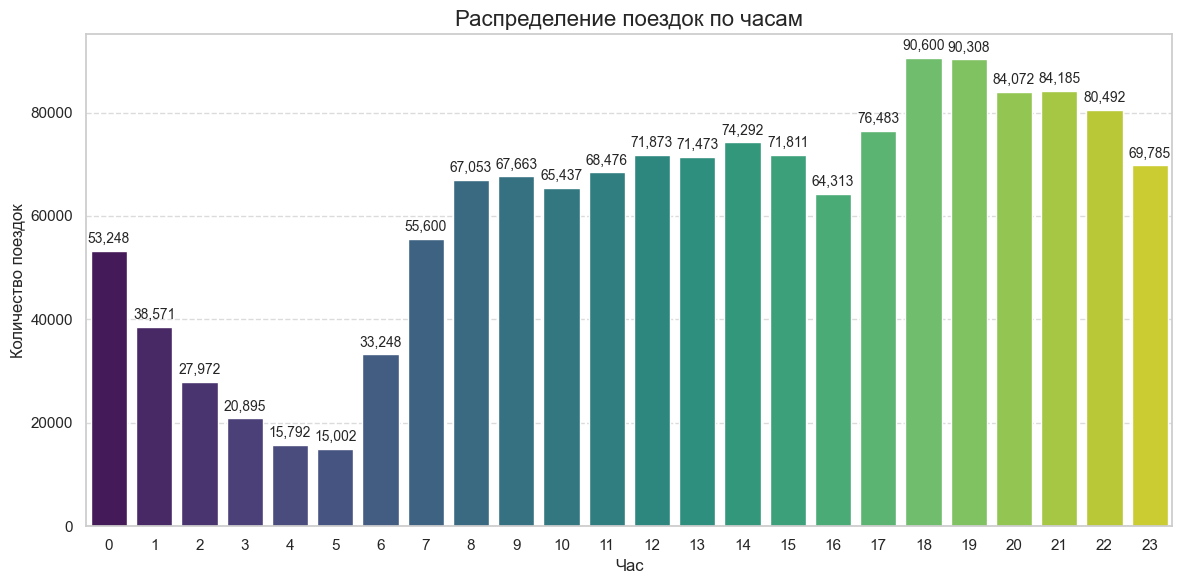

In [122]:
df['hour_of_day'] = df['pickup_datetime'].dt.hour
rides_by_hour = df['hour_of_day'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
hours = range(0,24)
sns.barplot(x=hours, y=rides_by_hour.values, palette='viridis')

plt.title('Распределение поездок по часам', fontsize=16)
plt.xlabel('Час', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(rides_by_hour.values):
    plt.text(i, value + 0.01*max(rides_by_hour), f'{value:,}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, поищите, как это делается). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

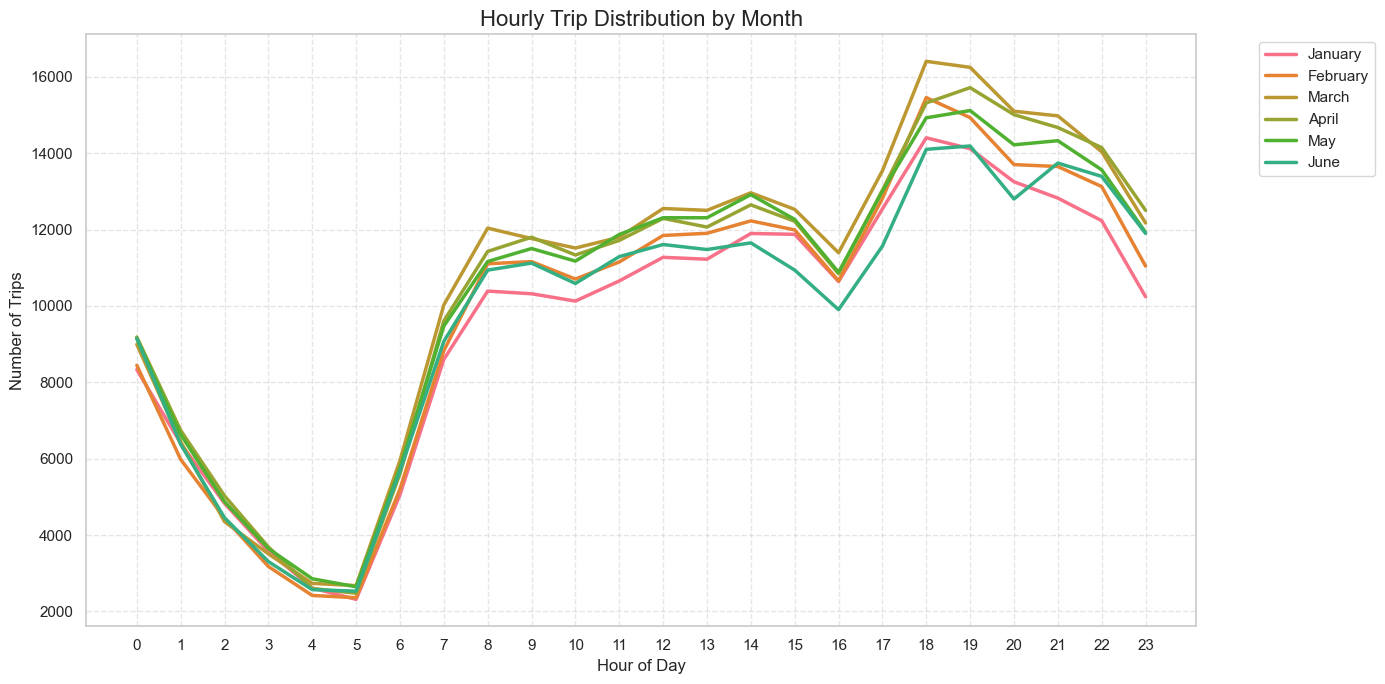

In [123]:
df = train_data.copy()
df['hour'] = train_data['pickup_datetime'].dt.hour
df['month'] = train_data['pickup_datetime'].dt.month_name()
df['day_of_week'] = train_data['pickup_datetime'].dt.day_name()

monthly_hourly = df.groupby(['month', 'hour']).size().unstack(level=0)

month_order = ['January', 'February', 'March', 'April', 'May', 'June']
monthly_hourly = monthly_hourly[month_order]

plt.figure(figsize=(14, 7))
palette = sns.color_palette("husl", n_colors=12)

for i, month in enumerate(monthly_hourly.columns):
    plt.plot(monthly_hourly.index, monthly_hourly[month], 
             label=month, color=palette[i], linewidth=2.5)

plt.title('Hourly Trip Distribution by Month', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.xticks(np.arange(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

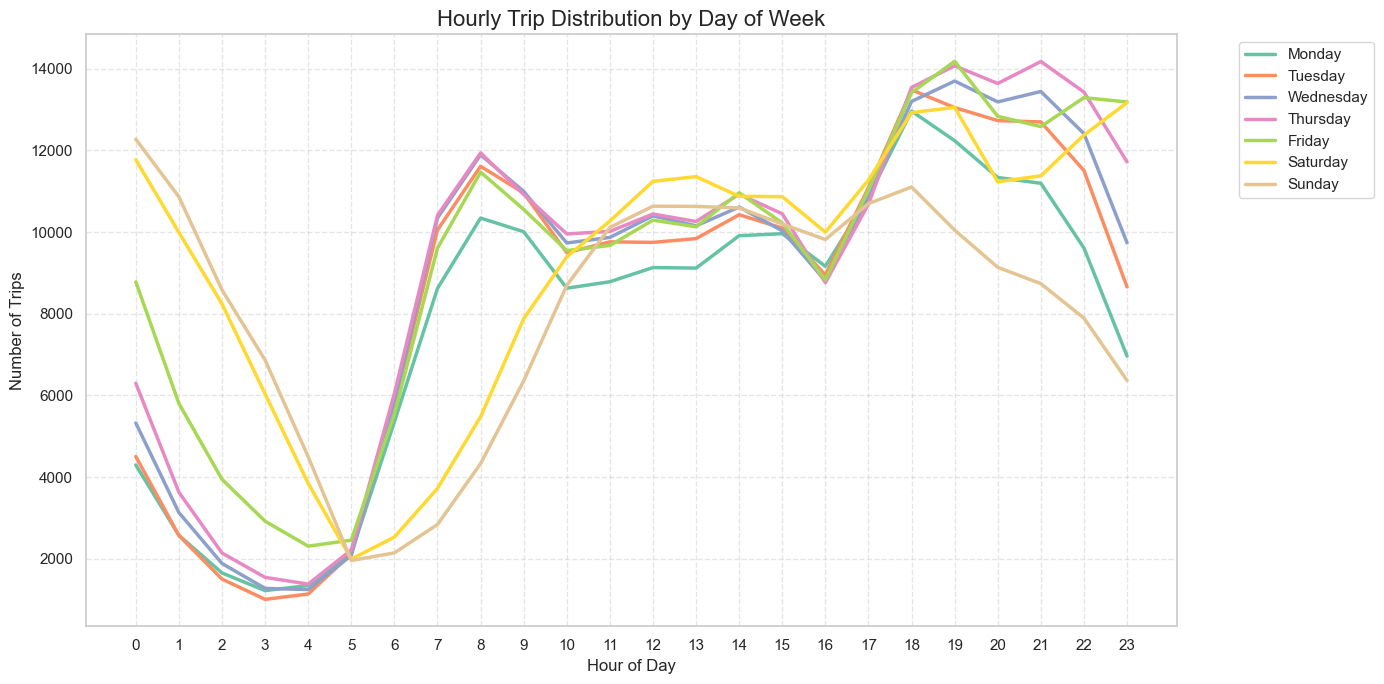

In [124]:
weekday_hourly = df.groupby(['day_of_week', 'hour']).size().unstack(level=0)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
             'Friday', 'Saturday', 'Sunday']
weekday_hourly = weekday_hourly[day_order]

plt.figure(figsize=(14, 7))
palette = sns.color_palette("Set2", n_colors=7)

for i, day in enumerate(weekday_hourly.columns):
    plt.plot(weekday_hourly.index, weekday_hourly[day], 
             label=day, color=palette[i], linewidth=2.5)

plt.title('Hourly Trip Distribution by Day of Week', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.xticks(np.arange(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**: Распределение поездок по часам практически идентичны для всех месяцев, отличаются только сдвигом вверх/вниз, то есть общим количеством поездок за месяц: при этом логическая закономерность по сезонным факторам, например погоде, не наблюдается. \ 
Распределение по дням недели также не особо отличается по будням (отличия есть только в вечернее время, но тренд одинаковый во все дни кроме пятницы, что логично, так как в это время наступает конец рабочей недели), но динамика поездок в выходные сильно отличается от будних, что логично, так как в эти дни у большинста людей другой лайфстайл.


**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [125]:
from sklearn.model_selection import train_test_split

X = train_data.drop(['trip_duration','log_trip_duration'], axis=1)
y = train_data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

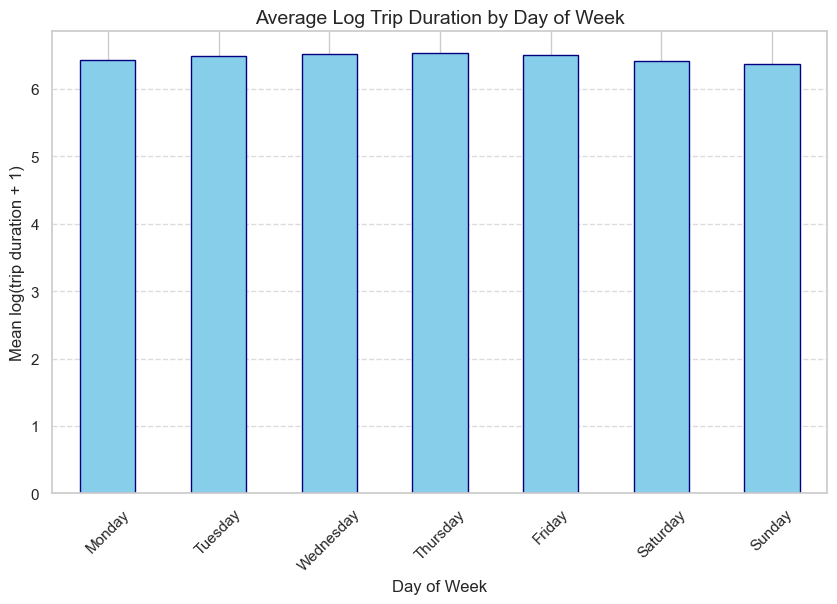

In [126]:
df = pd.concat([X_train, y_train], axis=1)

df['hour'] = train_data['pickup_datetime'].dt.hour
df['month'] = train_data['pickup_datetime'].dt.month_name()
df['day_of_week'] = train_data['pickup_datetime'].dt.day_name()

plt.figure(figsize=(10, 6))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


weekly_pattern = df.groupby('day_of_week')['log_trip_duration'].mean().reindex(day_order)

weekly_pattern.plot(kind='bar', color='skyblue', edgecolor='navy')
plt.title('Average Log Trip Duration by Day of Week', fontsize=14)
plt.xlabel('Day of Week')
plt.ylabel('Mean log(trip duration + 1)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

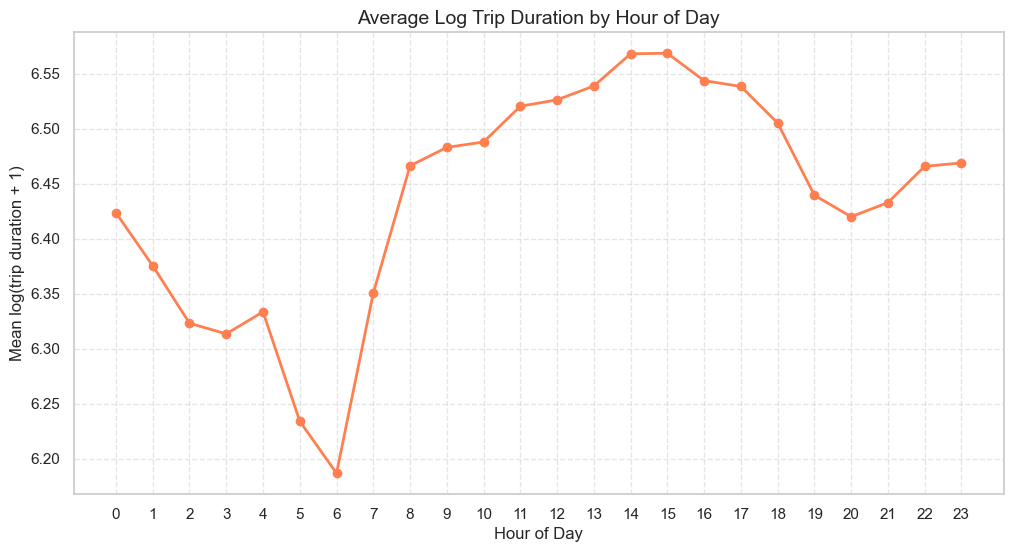

In [127]:
plt.figure(figsize=(12, 6))
hourly_pattern = df.groupby('hour')['log_trip_duration'].mean()

hourly_pattern.plot(kind='line', marker='o', color='coral', linewidth=2)
plt.title('Average Log Trip Duration by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Mean log(trip duration + 1)')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_56556/737955997.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1200x600 with 0 Axes>

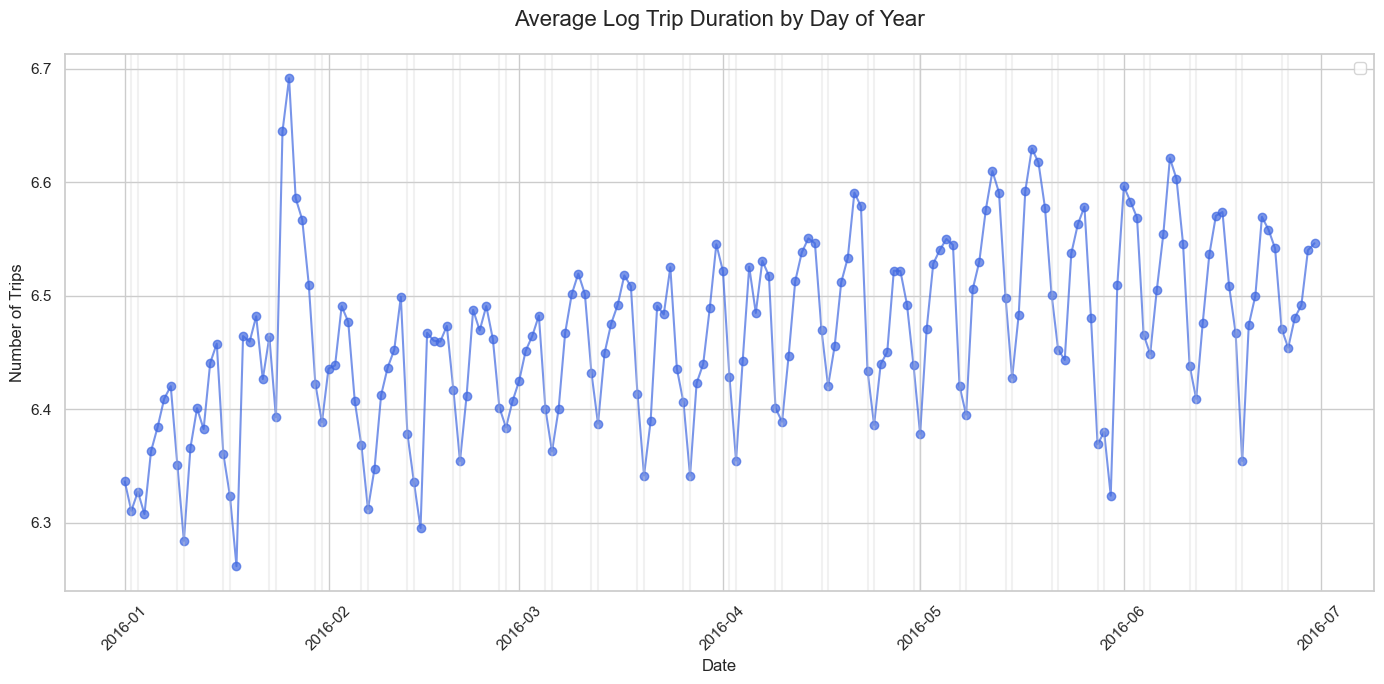

In [128]:
plt.figure(figsize=(12, 6))
df['pickup_date'] = df['pickup_datetime'].dt.date
daily_pattern = df.groupby('pickup_date')['log_trip_duration'].mean()

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")
plt.plot(daily_pattern.index, daily_pattern.values, 
         marker='o', linestyle='-', color='royalblue', alpha=0.7)

plt.title('Average Log Trip Duration by Day of Year', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

for i, date in enumerate(daily_pattern.index):
    if date.weekday() >= 5:
        plt.axvline(x=date, color='lightgray', alpha=0.3, linestyle='-')

plt.tight_layout()
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**: \
График зависимости таргета от дня недели похож на аналогичный с количеством поездок: и там и там в каждый день +- одинаковое значение, но 1. максимумы в разные дни (четверг и пятница), 2. отклонение логарифма от среднего по дням меньше, чем отклонение количества поездок от среднего. Схожесть объясняется тем, что в каждый день недели +- одинаковое и количество поездок, и среднее время в пути. 

График зависимости таргета от часа также похож на аналогичный с количеством поездок, но вечерняя динамика отличается: нет проседания в 16 и отрицательный тренд после 15. Схожесть объясняется влиянием одинаковых факторов на обе переменные: рано утром мало поездок, мало людей едут домой/на работу (вероятно самый длинный маршрут от точки А до точки Б в городской жизни) => длинных поездок меньше. Вечером динамика разная, так как люди возвращаются по домам в разное время: кто-то в 18, кто-то в 2-3 ночи => длинные поездки размазываются по бОльшему периоду и их заменяют ситуативные более короткие поездки, например в какие-нибудь заведения. 

На графике зависимости `log_trip_duration` от номера дня в году виден положительный тренд, хотя данный вывод для меня скорее контринтуитивен.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [129]:
train_data['day_of_week'] = train_data['pickup_datetime'].dt.dayofweek

train_data['month'] = train_data['pickup_datetime'].dt.month

train_data['hour'] = train_data['pickup_datetime'].dt.hour

train_data['day_of_year'] = train_data['pickup_datetime'].dt.dayofyear

target_dates = [
    pd.to_datetime('2016-01-23').date(),
    pd.to_datetime('2016-05-30').date()
]

train_data['is_anomaly'] = train_data['pickup_datetime'].dt.date.isin(target_dates)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?\
**Ответ**: Если мы зададим временной признак как числовой, мы простимулируем модель учитывать порядок на этом признаке. Порядок предполагает монотонную зависимость на данных. Мы наблюдали ее только на распределении таргета от номера дня (тот самый монотонный тренд). Общая динамика конечно содержит сезонность и аномалии, но эти зависимости уловят признаки `день недели` и `аномалии`, поэтому признак можно спокойно делать числовым. Соответственно в остальных признаках монотонный тренд не наблюдался, поэтому делать их численными не стоит - это ухудшит модель.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [130]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

features = ['day_of_week', 'month', 'hour', 'day_of_year', 'is_anomaly']
X = train_data[features]
y = train_data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_features = ['day_of_week', 'month', 'hour', 'is_anomaly']
numeric_features = ['day_of_year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)

rmsle_test = rmsle(y_test, model.predict(X_test))
print(f"RMSLE на тестовых данных: {rmsle_test:.3f}")

RMSLE на тестовых данных: 0.788


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [131]:
from typing import Iterable

def show_circles_on_map(
    latitude_values: Iterable[float],
    longitude_values: Iterable[float],
    color: str = "blue",
) -> folium.Map:
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    Works best on samples of size < 10k, too costly otherwise

    latitude_values: sample latitude values of a dataframe
    longitude_column: sample longitude values of a dataframe
    color: the color of circles to be drawn
    """

    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=100,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    m.add_child(folium.LatLngPopup())

    return m

Напишите функцию, которая вернет значения колонок `pickup_latitude`, `pickup_longitude` на каком-нибудь разумном кусочке датафрейма, например, `df.sample(1000)` и покажите на карте, используя `show_circles_on_map`

In [132]:
def sample_pickups(train_data):
    df = train_data.sample(1000)
    return df["pickup_latitude"], df["pickup_longitude"]

your_lat_values , your_lon_values= sample_pickups(train_data)

show_circles_on_map(your_lat_values, your_lon_values, color="midnightblue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?
**Ответ**: Основное скопление точек находится на манхэттене, остальные точки в основном хаотично разбросаны по другим районам города. Также за пределами манхэттена есть еще 2 выделяющихся кластера точек: это аэропорты. Будет полезно учитывать начало поездки из аэропорта, так как данные поездки очевидно дольше обычных из-за большого расстояния от города до аэропорта и эту зависимость не учитывается в остальных переменных.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [133]:
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Рассчитывает расстояние в км между двумя точками на Земле
    используя формулу Haversine.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371
    return c * r

train_data['haversine'] = haversine_distance(
    train_data['pickup_longitude'],
    train_data['pickup_latitude'],
    train_data['dropoff_longitude'],
    train_data['dropoff_latitude']
)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [134]:
train_data["log_haversine"] = np.log1p(train_data["haversine"])

Посчитайте корреляцию и убедитесь, что логарифм расстояния лучше отражает таргет, чем просто расстояние:

In [135]:
from scipy import stats
hav_corr, hav_pvalue = stats.pearsonr(train_data['haversine'], train_data['log_trip_duration'])
loghav_corr, loghav_pvalue = stats.pearsonr(train_data['log_haversine'], train_data['log_trip_duration'])


print(f"Корреляция haversine: {hav_corr:.3f}")
print(f"Корреляция log_haversine: {loghav_corr:.3f}")

Корреляция haversine: 0.574
Корреляция log_haversine: 0.750


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

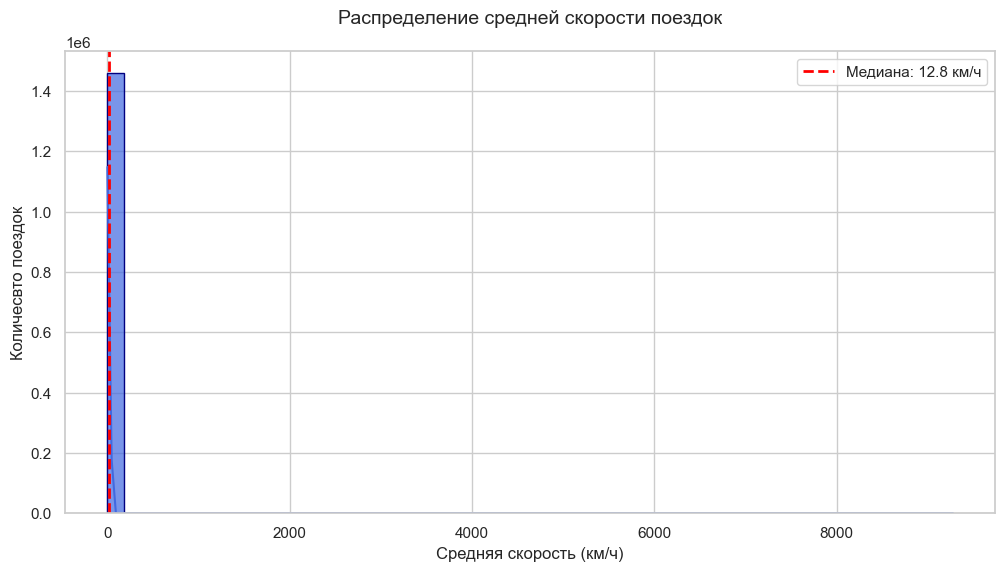

In [136]:
train_data["mean_speed"] = train_data["haversine"]/(train_data["trip_duration"]/3600)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

ax = sns.histplot(
    train_data['mean_speed'], 
    bins=50, 
    kde=True,
    color='royalblue',
    edgecolor='navy',
    alpha=0.7
)

median_speed = np.median(train_data['mean_speed'])
plt.axvline(
    x=median_speed, 
    color='red', 
    linestyle='--', 
    linewidth=2,
    label=f'Медиана: {median_speed:.1f} км/ч'
)

plt.title('Распределение средней скорости поездок', fontsize=14, pad=20)
plt.xlabel('Средняя скорость (км/ч)', fontsize=12)
plt.ylabel('Количесвто поездок', fontsize=12)
plt.legend()

plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

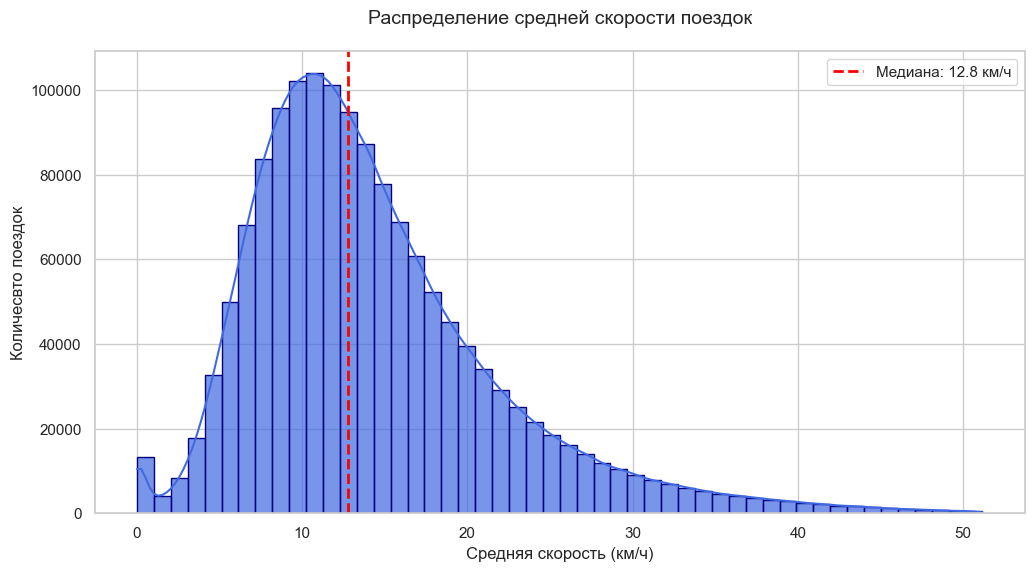

In [137]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

Q1 = train_data['mean_speed'].quantile(0.1)
Q3 = train_data['mean_speed'].quantile(0.9)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

speed_filtered = train_data[
    (train_data['mean_speed'] >= lower_bound) & 
    (train_data['mean_speed'] <= upper_bound)
]['mean_speed']

ax = sns.histplot(
    speed_filtered, 
    bins=50, 
    kde=True,
    color='royalblue',
    edgecolor='navy',
    alpha=0.7
)

median_speed = np.median(speed_filtered)
plt.axvline(
    x=median_speed, 
    color='red', 
    linestyle='--', 
    linewidth=2,
    label=f'Медиана: {median_speed:.1f} км/ч'
)

plt.title('Распределение средней скорости поездок', fontsize=14, pad=20)
plt.xlabel('Средняя скорость (км/ч)', fontsize=12)
plt.ylabel('Количесвто поездок', fontsize=12)
plt.legend()

plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте Heatmap-график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_56556/2504393623.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_filtered_df['day_name'] = speed_filtered_df['day_of_week'].map(lambda x: day_names[x])


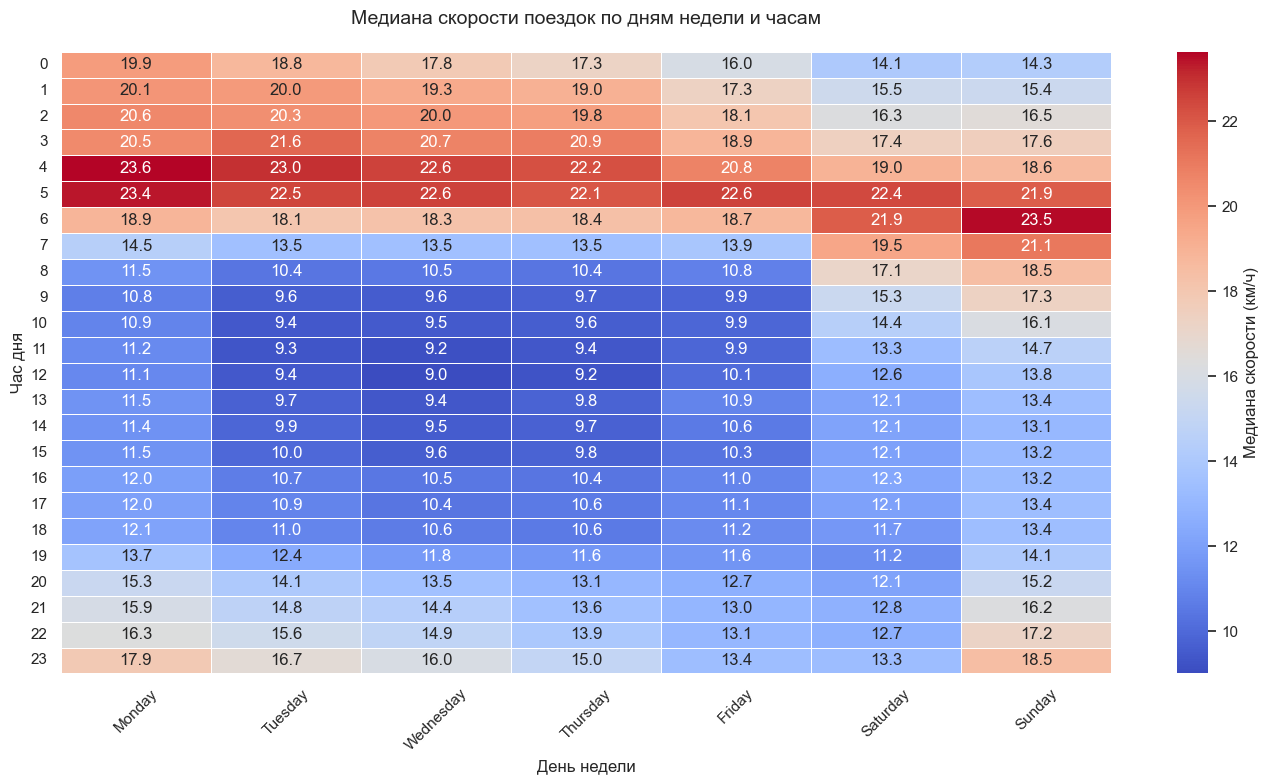

In [138]:
speed_filtered_df = train_data[
    (train_data['mean_speed'] >= lower_bound) & 
    (train_data['mean_speed'] <= upper_bound)
]

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
speed_filtered_df['day_name'] = speed_filtered_df['day_of_week'].map(lambda x: day_names[x])

pivot_table = speed_filtered_df.pivot_table(
    index='hour',
    columns='day_name',
    values='mean_speed',
    aggfunc='median'
)

pivot_table = pivot_table[day_names]

plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_table, 
    cmap='coolwarm', 
    annot=True, 
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={'label': 'Медиана скорости (км/ч)'}
)

plt.title('Медиана скорости поездок по дням недели и часам', fontsize=14, pad=20)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Час дня', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения? \
**Ответ**: мы нашли значения скорости, используя значения таргета. То есть по скорости мы легко можем восстановить значения таргета для каждой поездки: допущена утечка. Модель не будет находить зависимости в данных, а просто воспользуется формулой $\log t = \log s - \log{v_{\text{ср}}}$

In [139]:
train_data = train_data.drop("mean_speed", axis=1)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.\
**Ответ**: скорость минимальна с 8 до 19 (в выходные небольшой сдвиг) - периоды большой загрузки на дорогах.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [140]:
train_data["is_traffic_jam"] = (train_data['hour']>=8) & (train_data['hour']<=19)
train_data["is_road_free"] = (train_data['hour']>=0) & (train_data['hour']<=6)

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?\
**Ответ**: описывал выше

In [141]:
def is_in_square(lower_left, upper_right, lat, lon):
    return (lower_left[0] <= lat <= upper_right[0]) and \
           (lower_left[1] <= lon <= upper_right[1])

Kennedy_lower_left = (40.6321, -73.8098)
Kennedy_upper_right = (40.6567, -73.7610)

train_data['is_pickup_in_Kennedy_Airport'] = train_data.apply(
    lambda row: is_in_square(Kennedy_lower_left, Kennedy_upper_right, row['pickup_latitude'], row['pickup_longitude']),
    axis=1
)

train_data['is_dropoff_in_Kennedy_Airport'] = train_data.apply(
    lambda row: is_in_square(Kennedy_lower_left, Kennedy_upper_right, row['dropoff_latitude'], row['dropoff_longitude']),
    axis=1
)

LaGuardia_lower_left = (40.7672, -73.8876)
LaGuardia_upper_right = (40.7803, -73.8565)

train_data['is_pickup_in_LaGuardia_Airport'] = train_data.apply(
    lambda row: is_in_square(LaGuardia_lower_left, LaGuardia_upper_right, row['pickup_latitude'], row['pickup_longitude']),
    axis=1
)

train_data['is_dropoff_in_LaGuardia_Airport'] = train_data.apply(
    lambda row: is_in_square(LaGuardia_lower_left, LaGuardia_upper_right, row['dropoff_latitude'], row['dropoff_longitude']),
    axis=1
)

Для каждого из созданных признаков нарисуйте "ящик с усами" (aka boxplot) распределения логарифма времени поездки

/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_56556/1042956056.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_56556/1042956056.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Нет', 'Да'])
/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_56556/1042956056.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_56556/1042956056.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks(

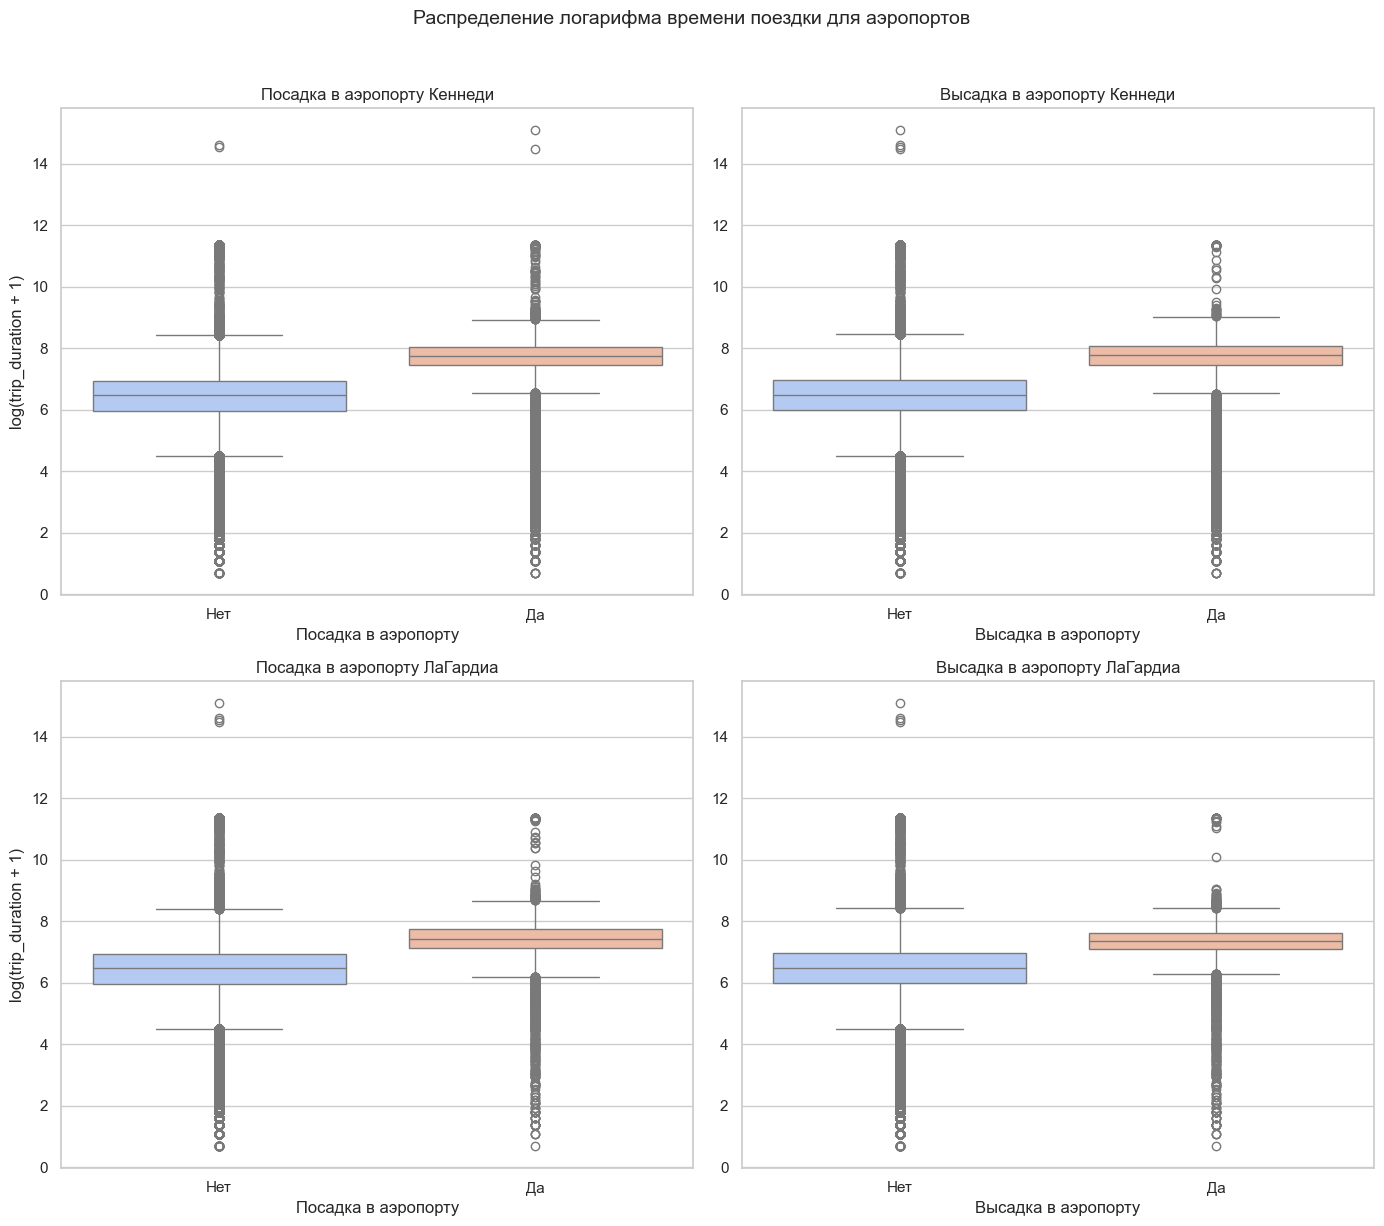

In [142]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
plt.suptitle('Распределение логарифма времени поездки для аэропортов', y=1.02, fontsize=14)

sns.boxplot(
    x='is_pickup_in_Kennedy_Airport',
    y=np.log1p(train_data['trip_duration']),
    data=train_data,
    ax=axes[0, 0],
    palette='coolwarm'
)
axes[0, 0].set_title('Посадка в аэропорту Кеннеди')
axes[0, 0].set_xlabel('Посадка в аэропорту')
axes[0, 0].set_ylabel('log(trip_duration + 1)')
axes[0, 0].set_xticklabels(['Нет', 'Да'])

sns.boxplot(
    x='is_dropoff_in_Kennedy_Airport',
    y=np.log1p(train_data['trip_duration']),
    data=train_data,
    ax=axes[0, 1],
    palette='coolwarm'
)
axes[0, 1].set_title('Высадка в аэропорту Кеннеди')
axes[0, 1].set_xlabel('Высадка в аэропорту')
axes[0, 1].set_ylabel('')
axes[0, 1].set_xticklabels(['Нет', 'Да'])

sns.boxplot(
    x='is_pickup_in_LaGuardia_Airport',
    y=np.log1p(train_data['trip_duration']),
    data=train_data,
    ax=axes[1, 0],
    palette='coolwarm'
)
axes[1, 0].set_title('Посадка в аэропорту ЛаГардиа')
axes[1, 0].set_xlabel('Посадка в аэропорту')
axes[1, 0].set_ylabel('log(trip_duration + 1)')
axes[1, 0].set_xticklabels(['Нет', 'Да'])

sns.boxplot(
    x='is_dropoff_in_LaGuardia_Airport',
    y=np.log1p(train_data['trip_duration']),
    data=train_data,
    ax=axes[1, 1],
    palette='coolwarm'
)
axes[1, 1].set_title('Высадка в аэропорту ЛаГардиа')
axes[1, 1].set_xlabel('Высадка в аэропорту')
axes[1, 1].set_ylabel('')
axes[1, 1].set_xticklabels(['Нет', 'Да'])

plt.tight_layout()
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?\
**Ответ**: Да, каждый признак выявляет разницу в распределении данных: все поездки, связанные с аэропортами, значительно дольше.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [143]:
from sklearn.base import BaseEstimator, TransformerMixin

def split_rectangle(lower_left, upper_right, rows=4, cols=3):
    """
    Разделяет прямоугольник на равные части.
    
    Параметры:
        lower_left: (lat, lon) - нижний левый угол
        upper_right: (lat, lon) - верхний правый угол
        rows: количество строк (по вертикали)
        cols: количество столбцов (по горизонтали)
    
    Возвращает:
        Словарь {номер_зоны: (lower_left, upper_right)}
    """
    lat_min, lon_min = lower_left
    lat_max, lon_max = upper_right
    
    delta_lat = (lat_max - lat_min) / rows
    delta_lon = (lon_max - lon_min) / cols
    
    zones = {}
    zone_num = 1
    
    for i in range(rows):
        for j in range(cols):
            ll = (lat_min + i * delta_lat, lon_min + j * delta_lon)
            ur = (lat_min + (i + 1) * delta_lat, lon_min + (j + 1) * delta_lon)
            
            zones[zone_num] = (ll, ur)
            zone_num += 1
    
    return zones

def get_zone_number(lat, lon, zones):
    for zone_num, (ll, ur) in zones.items():
        if (ll[0] <= lat <= ur[0]) and (ll[1] <= lon <= ur[1]):
            return zone_num
    return -1

# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.zones={}
        self.lower_left = (40.7002, -74.0200)
        self.upper_right = (40.8099, -73.9270)

    def show_map(self):
        # you may want to visualize cells
        from folium.features import DivIcon
        
        center_lat = (self.lower_left[0] + self.upper_right[0]) / 2
        center_lon = (self.lower_left[1] + self.upper_right[1]) / 2
        
        m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
                
        for zone_num, (ll, ur) in self.zones.items():
            center_lat_zone = (ll[0] + ur[0]) / 2
            center_lon_zone = (ll[1] + ur[1]) / 2
            
            folium.Rectangle(
                bounds=[ll, ur],
                color='red',
                fill=True,
                fill_opacity=0.2,
                popup=f'{zone_num}',
                weight=2
            ).add_to(m)
            
            folium.map.Marker(
                [center_lat_zone, center_lon_zone],
                icon=DivIcon(
                    icon_size=(150,36),
                    icon_anchor=(11,20),
                    html=f'<div style="font-size: 18pt; color: {"red"}">{zone_num}</div>'
                )
            ).add_to(m)
        
        return m


    def fit(self, X=None, y=None):
        self.zones = split_rectangle(self.lower_left, self.upper_right, rows=4, cols=3)
        return self

    def transform(self, X, y=None):
        X['pickup_zone'] = X.apply(
            lambda row: get_zone_number(row['pickup_latitude'], row['pickup_longitude'], self.zones),
            axis=1
        )
        X['dropoff_zone'] = X.apply(
            lambda row: get_zone_number(row['dropoff_latitude'], row['dropoff_longitude'], self.zones),
            axis=1
        )
        return X

In [144]:
X = train_data.sample(100)
y = X['log_trip_duration']
mgd = MapGridTransformer()
mgd.fit(X,y)
mgd.transform(X,y).head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,haversine,log_haversine,is_traffic_jam,is_road_free,is_pickup_in_Kennedy_Airport,is_dropoff_in_Kennedy_Airport,is_pickup_in_LaGuardia_Airport,is_dropoff_in_LaGuardia_Airport,pickup_zone,dropoff_zone
20900,id1764503,2,2016-05-14 15:57:02,5,-74.001877,40.746460,-73.997742,40.741291,N,253,...,0.672089,0.514074,True,False,False,False,False,False,4,4
1375196,id1962067,2,2016-05-20 13:54:02,1,-74.002007,40.746960,-73.991653,40.738480,N,404,...,1.284481,0.826139,True,False,False,False,False,False,4,4
1130867,id1190955,1,2016-03-19 11:52:34,1,-73.994164,40.751076,-73.992928,40.768208,N,561,...,1.907812,1.067401,True,False,False,False,False,False,4,7
446103,id1009919,2,2016-06-07 00:35:38,1,-73.979263,40.761681,-73.996902,40.762859,N,473,...,1.491373,0.912834,False,True,False,False,False,False,8,7
97943,id2287904,2,2016-06-28 06:58:35,2,-73.992569,40.743118,-73.976601,40.739368,N,341,...,1.408442,0.878980,False,True,False,False,False,False,4,5


In [145]:
mgd.show_map()

In [146]:
train_data = mgd.transform(train_data)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [147]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

features = ['day_of_week', 'month', 'hour', 'day_of_year', 'is_anomaly']


features = [
    'day_of_week',
    'month',
    'hour',
    'day_of_year',
    'is_anomaly',
    'log_haversine',
    'is_traffic_jam',
    'is_road_free', 
    'is_pickup_in_Kennedy_Airport',
    'is_dropoff_in_Kennedy_Airport', 
    'is_pickup_in_LaGuardia_Airport',
    'is_dropoff_in_LaGuardia_Airport',
    'pickup_zone',
    'dropoff_zone'
]


X = train_data[features]
y = train_data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_features = [
    'day_of_week',
    'month',
    'hour',
    'is_anomaly',
    'is_traffic_jam',
    'is_road_free',
    'is_pickup_in_Kennedy_Airport',
    'is_dropoff_in_Kennedy_Airport', 
    'is_pickup_in_LaGuardia_Airport',
    'is_dropoff_in_LaGuardia_Airport',
    'pickup_zone',
    'dropoff_zone'
]

numeric_features = ['day_of_year', 'log_haversine']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)

rmsle_test = rmsle(y_test, model.predict(X_test))
print(f"RMSLE на тестовых данных: {rmsle_test:.3f}")

RMSLE на тестовых данных: 0.481


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.
**Ответ**: \
`vendor_id` - id поставщика записывающего устройства. Вероятно разные механизмы записи и в среднем устройства какого-то из поставщиков могут завышать/занижать или же более частые сбои\
`passenger_count` - количество пассажиров. может быть полезен, так как у компании из людей цена на такси ниже (обычно делится между всеми) и поэтому поведение компаний отличается от пассажиров-одиночек.\
`store_and_fwd_flag` - сохранялась ли запись на устройстве. вероятно тоже маркирует разное поведение: если сохранялось - то есть больше данных о поездках в места без сети, то есть за пределы города, и соответственно длина поездки в таком случае выше.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [148]:
features = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']
for feat in features:
    print(feat, ": ", len(train_data[feat].unique()))

vendor_id :  2
passenger_count :  10
store_and_fwd_flag :  2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_56556/879860115.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_56556/879860115.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_56556/879860115.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


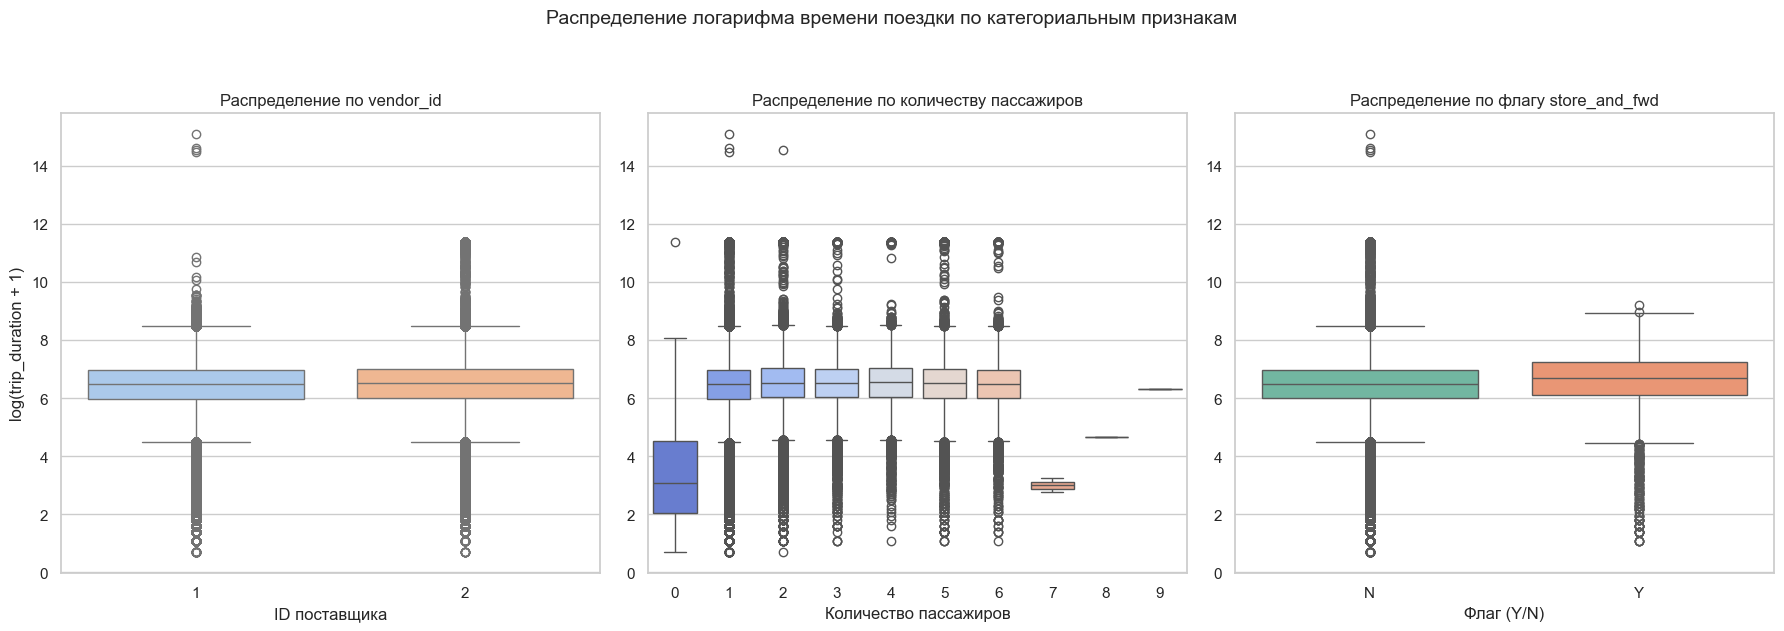

In [149]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle('Распределение логарифма времени поездки по категориальным признакам', y=1.05, fontsize=14)

sns.boxplot(
    x='vendor_id',
    y=np.log1p(train_data['trip_duration']),
    data=train_data,
    ax=axes[0],
    palette='pastel'
)
axes[0].set_title('Распределение по vendor_id')
axes[0].set_xlabel('ID поставщика')
axes[0].set_ylabel('log(trip_duration + 1)')

sns.boxplot(
    x='passenger_count',
    y=np.log1p(train_data['trip_duration']),
    data=train_data,
    ax=axes[1],
    palette='coolwarm'
)
axes[1].set_title('Распределение по количеству пассажиров')
axes[1].set_xlabel('Количество пассажиров')
axes[1].set_ylabel('')

sns.boxplot(
    x='store_and_fwd_flag',
    y=np.log1p(train_data['trip_duration']),
    data=train_data,
    ax=axes[2],
    palette='Set2'
)
axes[2].set_title('Распределение по флагу store_and_fwd')
axes[2].set_xlabel('Флаг (Y/N)')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [150]:
train_data['vendor_id'] = train_data['vendor_id'].map({2: 1, 1: 0})
train_data['store_and_fwd_flag_encoded'] = train_data['store_and_fwd_flag'].map({'Y': 1, 'N': 0})

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?\
**Ответ**: `vendor_id` и `store_and_fwd_flag` +- бесполезны, значения отличаются только количеством и масштабом выбросов. `passenger_count` тоже бесполезен для большинства значений, но все равно улавливает отличия при 0,7,8 пассажирах, поэтому качество все равно немного улучшит.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [151]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

features = [
    'day_of_week',
    'month',
    'hour',
    'day_of_year',
    'is_anomaly',
    'log_haversine',
    'is_traffic_jam',
    'is_road_free', 
    'is_pickup_in_Kennedy_Airport',
    'is_dropoff_in_Kennedy_Airport', 
    'is_pickup_in_LaGuardia_Airport',
    'is_dropoff_in_LaGuardia_Airport',
    'pickup_zone',
    'dropoff_zone',
    'vendor_id',
    'store_and_fwd_flag',
    'passenger_count'
]


X = train_data[features]
y = train_data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_features = [
    'day_of_week',
    'month',
    'hour',
    'is_anomaly',
    'is_traffic_jam',
    'is_road_free',
    'is_pickup_in_Kennedy_Airport',
    'is_dropoff_in_Kennedy_Airport', 
    'is_pickup_in_LaGuardia_Airport',
    'is_dropoff_in_LaGuardia_Airport',
    'pickup_zone',
    'dropoff_zone',
    'vendor_id',
    'store_and_fwd_flag',
    'passenger_count'
]

numeric_features = ['day_of_year', 'log_haversine']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)

rmsle_test = rmsle(y_test, model.predict(X_test))
print(f"RMSLE на тестовых данных: {rmsle_test:.3f}")

RMSLE на тестовых данных: 0.480


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

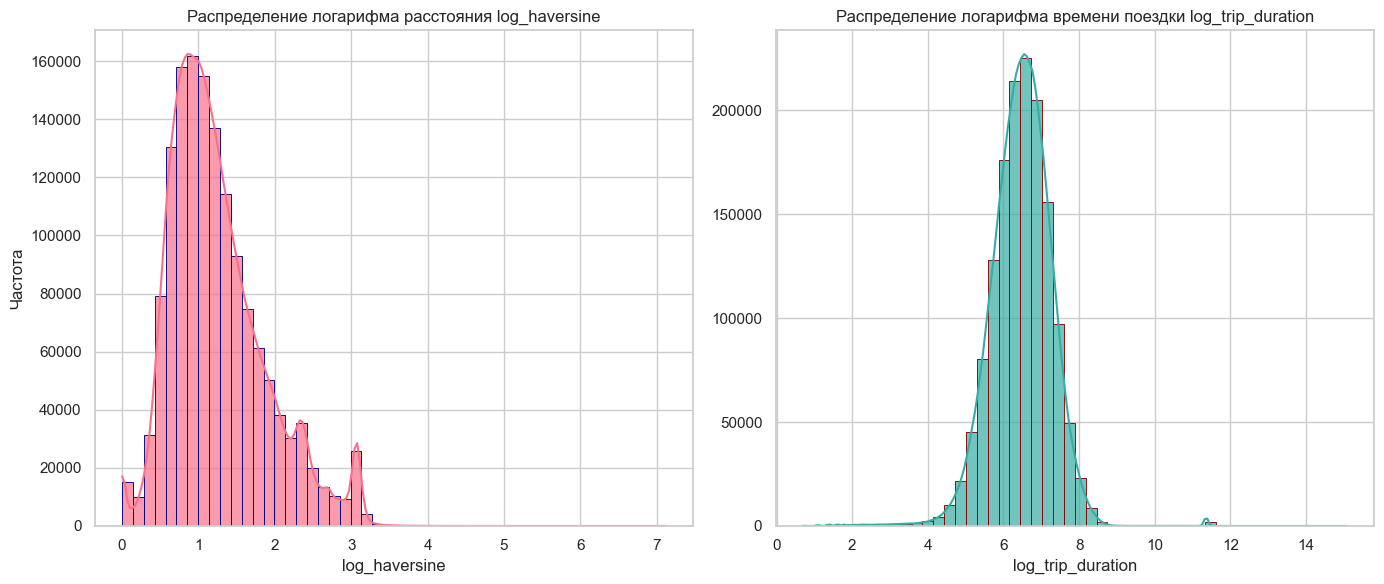

In [152]:
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
palette = sns.color_palette("husl", 2)

plt.subplot(1, 2, 1)
sns.histplot(
    train_data['log_haversine'],
    bins=50,
    kde=True,
    color=palette[0],
    edgecolor='navy',
    alpha=0.7
)
plt.title('Распределение логарифма расстояния log_haversine')
plt.xlabel('log_haversine')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(
    train_data['log_trip_duration'],
    bins=50,
    kde=True,
    color=palette[1],
    edgecolor='darkred',
    alpha=0.7
)
plt.title('Распределение логарифма времени поездки log_trip_duration')
plt.xlabel('log_trip_duration')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [159]:
train_data = train_data[(train_data['log_haversine']<3.2) & (train_data['log_haversine']>0.15)]
train_data = train_data[(train_data['log_trip_duration']<8.5) & (train_data['log_trip_duration']>3.8)]

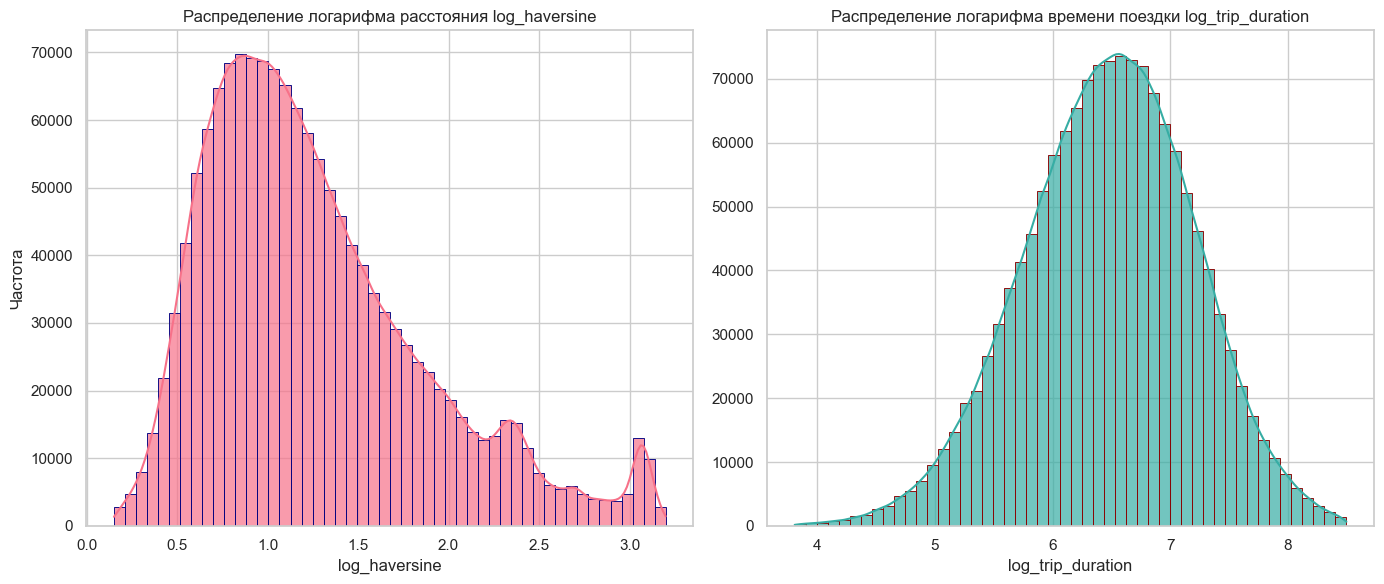

In [161]:
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
palette = sns.color_palette("husl", 2)

plt.subplot(1, 2, 1)
sns.histplot(
    train_data['log_haversine'],
    bins=50,
    kde=True,
    color=palette[0],
    edgecolor='navy',
    alpha=0.7
)
plt.title('Распределение логарифма расстояния log_haversine')
plt.xlabel('log_haversine')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(
    train_data['log_trip_duration'],
    bins=50,
    kde=True,
    color=palette[1],
    edgecolor='darkred',
    alpha=0.7
)
plt.title('Распределение логарифма времени поездки log_trip_duration')
plt.xlabel('log_trip_duration')
plt.ylabel('')

plt.tight_layout()
plt.show()

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

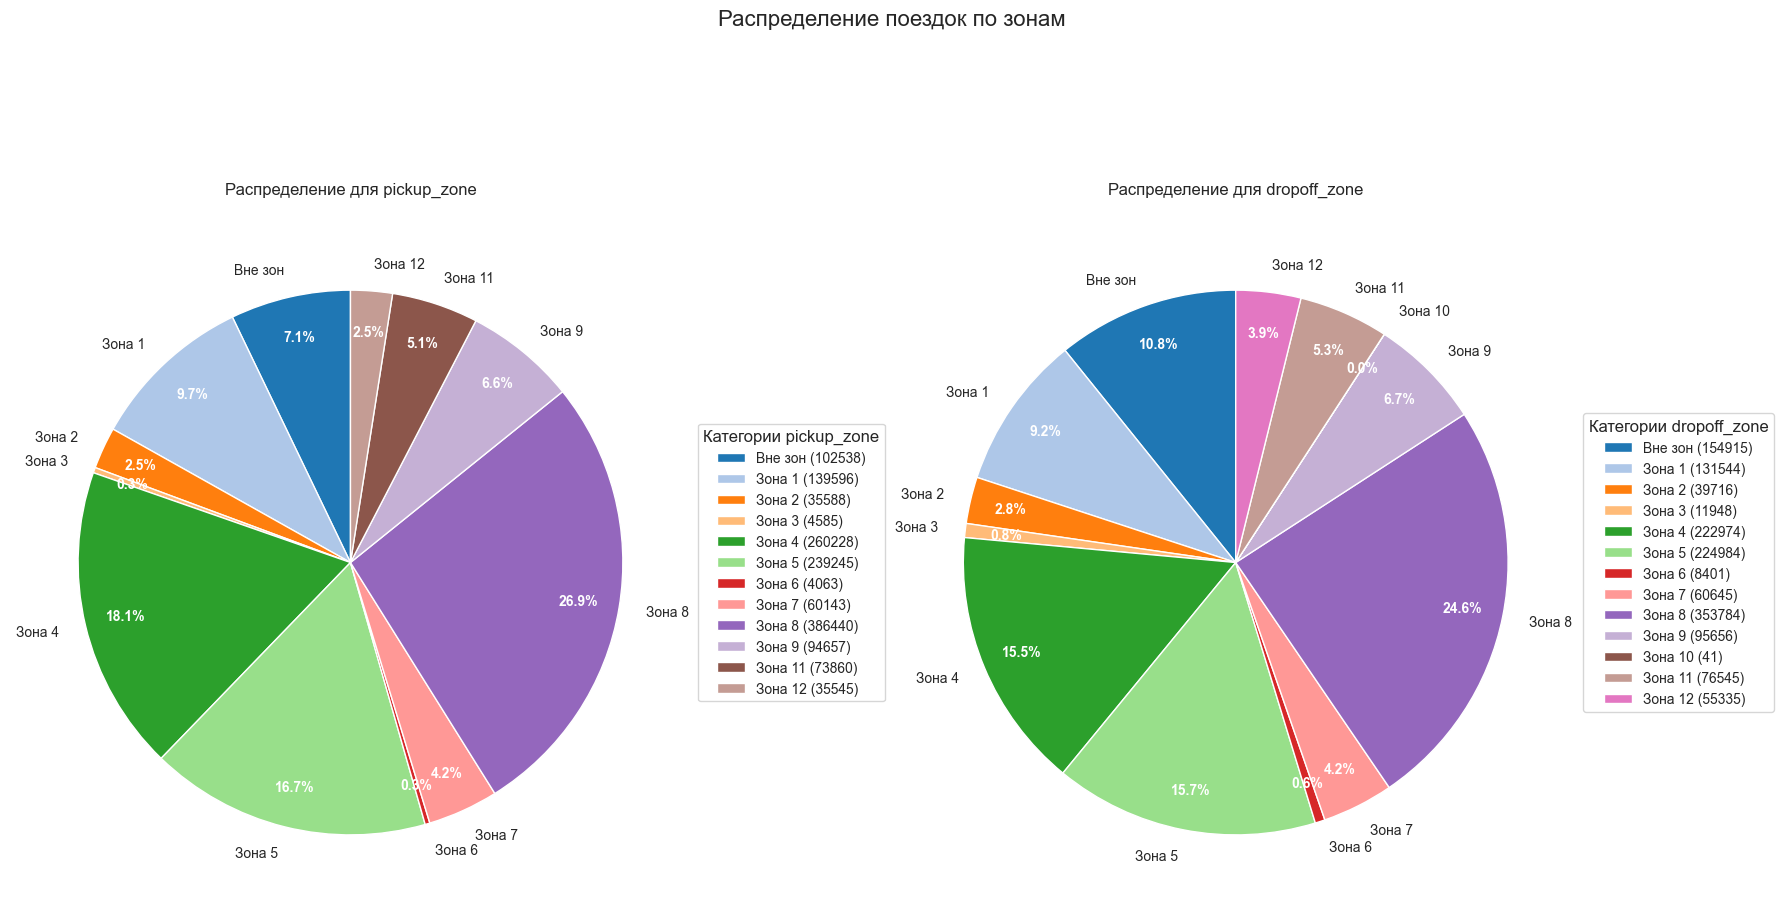

In [165]:
import matplotlib.pyplot as plt

cat_features = ['pickup_zone', 'dropoff_zone']

fig, axes = plt.subplots(1, 2, figsize=(18, 9))
fig.suptitle('Распределение поездок по зонам', fontsize=16, y=1.05)

colors = plt.cm.tab20.colors

for i, feature in enumerate(cat_features):
    value_counts = train_data[feature].value_counts().sort_index()
    
    wedges, texts, autotexts = axes[i].pie(
        value_counts,
        labels=[f'Зона {idx}' if idx != -1 else 'Вне зон' for idx in value_counts.index],
        colors=colors[:len(value_counts)],
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.85,
        textprops={'fontsize': 10}
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
    
    axes[i].legend(
        wedges,
        [f'Зона {idx} ({count})' if idx != -1 else f'Вне зон ({count})' 
         for idx, count in zip(value_counts.index, value_counts)],
        title=f'Категории {feature}',
        loc='center left',
        bbox_to_anchor=(1, 0, 0.5, 1),
        fontsize=10
    )
    
    axes[i].set_title(f'Распределение для {feature}', pad=20)

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.3)
plt.show()

In [173]:
train_data['pickup_zone'] = train_data['pickup_zone'].replace([3, 6], -1)
train_data['dropoff_zone'] = train_data['dropoff_zone'].replace([3, 6], -1)

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [177]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

features = [
    'day_of_week',
    'month',
    'hour',
    'day_of_year',
    'is_anomaly',
    'log_haversine',
    'is_traffic_jam',
    'is_road_free', 
    'is_pickup_in_Kennedy_Airport',
    'is_dropoff_in_Kennedy_Airport', 
    'is_pickup_in_LaGuardia_Airport',
    'is_dropoff_in_LaGuardia_Airport',
    'pickup_zone',
    'dropoff_zone'
]


X = train_data[features]
y = train_data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_features = [
    'day_of_week',
    'month',
    'hour',
    'is_anomaly',
    'is_traffic_jam',
    'is_road_free',
    'is_pickup_in_Kennedy_Airport',
    'is_dropoff_in_Kennedy_Airport', 
    'is_pickup_in_LaGuardia_Airport',
    'is_dropoff_in_LaGuardia_Airport',
    'pickup_zone',
    'dropoff_zone'
]

numeric_features = ['day_of_year', 'log_haversine']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)

rmsle_test = rmsle(y_test, model.predict(X_test))
print(f"RMSLE на тестовых данных: {rmsle_test:.3f}")

RMSLE на тестовых данных: 0.402


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [181]:
def get_feature_names(pipeline):
    num_features = numeric_features
    
    ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
    cat_features = ohe.get_feature_names_out(categorical_features)
    
    all_features = np.concatenate([num_features, cat_features])
    return all_features

final_features = get_feature_names(model)
print(f"Общее количество признаков после OHE: {len(final_features)}")
print("Признаки", final_features)

Общее количество признаков после OHE: 74
Признаки ['day_of_year' 'log_haversine' 'day_of_week_0' 'day_of_week_1'
 'day_of_week_2' 'day_of_week_3' 'day_of_week_4' 'day_of_week_5'
 'day_of_week_6' 'month_1' 'month_2' 'month_3' 'month_4' 'month_5'
 'month_6' 'hour_0' 'hour_1' 'hour_2' 'hour_3' 'hour_4' 'hour_5' 'hour_6'
 'hour_7' 'hour_8' 'hour_9' 'hour_10' 'hour_11' 'hour_12' 'hour_13'
 'hour_14' 'hour_15' 'hour_16' 'hour_17' 'hour_18' 'hour_19' 'hour_20'
 'hour_21' 'hour_22' 'hour_23' 'is_anomaly_False' 'is_anomaly_True'
 'is_traffic_jam_False' 'is_traffic_jam_True' 'is_road_free_False'
 'is_road_free_True' 'is_pickup_in_Kennedy_Airport_False'
 'is_pickup_in_Kennedy_Airport_True' 'is_dropoff_in_Kennedy_Airport_False'
 'is_dropoff_in_Kennedy_Airport_True'
 'is_pickup_in_LaGuardia_Airport_False'
 'is_pickup_in_LaGuardia_Airport_True'
 'is_dropoff_in_LaGuardia_Airport_False'
 'is_dropoff_in_LaGuardia_Airport_True' 'pickup_zone_-1' 'pickup_zone_1'
 'pickup_zone_2' 'pickup_zone_4' 'pickup_zo

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [182]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

features = [
    'day_of_week',
    'month',
    'hour',
    'day_of_year',
    'is_anomaly',
    'log_haversine',
    'is_traffic_jam',
    'is_road_free', 
    'is_pickup_in_Kennedy_Airport',
    'is_dropoff_in_Kennedy_Airport', 
    'is_pickup_in_LaGuardia_Airport',
    'is_dropoff_in_LaGuardia_Airport',
    'pickup_zone',
    'dropoff_zone'
]


X = train_data[features]
y = train_data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_features = [
    'day_of_week',
    'month',
    'hour',
    'is_anomaly',
    'is_traffic_jam',
    'is_road_free',
    'is_pickup_in_Kennedy_Airport',
    'is_dropoff_in_Kennedy_Airport', 
    'is_pickup_in_LaGuardia_Airport',
    'is_dropoff_in_LaGuardia_Airport',
    'pickup_zone',
    'dropoff_zone'
]

numeric_features = ['day_of_year', 'log_haversine']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

model.fit(X_train, y_train)

rmsle_test = rmsle(y_test, model.predict(X_test))
print(f"RMSLE на тестовых данных: {rmsle_test:.3f}")

RMSLE на тестовых данных: 0.723


**Ответ**: Ridge в разы лучше.

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [186]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

features = [
    'day_of_week',
    'month',
    'hour',
    'day_of_year',
    'is_anomaly',
    'log_haversine',
    'is_traffic_jam',
    'is_road_free', 
    'is_pickup_in_Kennedy_Airport',
    'is_dropoff_in_Kennedy_Airport', 
    'is_pickup_in_LaGuardia_Airport',
    'is_dropoff_in_LaGuardia_Airport',
    'pickup_zone',
    'dropoff_zone'
]


X = train_data[features]
y = train_data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_features = [
    'day_of_week',
    'month',
    'hour',
    'is_anomaly',
    'is_traffic_jam',
    'is_road_free',
    'is_pickup_in_Kennedy_Airport',
    'is_dropoff_in_Kennedy_Airport', 
    'is_pickup_in_LaGuardia_Airport',
    'is_dropoff_in_LaGuardia_Airport',
    'pickup_zone',
    'dropoff_zone'
]

numeric_features = ['day_of_year', 'log_haversine']

param_grid = {'regressor__alpha': np.logspace(-3, 3, 13)}  # от 0.001 до 1000

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

ridge_grid = GridSearchCV(
    ridge_pipeline,
    param_grid,
    cv=5,
    scoring=rmsle_scorer,
    n_jobs=-1,
    verbose=2
)
ridge_grid.fit(X_train, y_train)

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=10000))
])

lasso_grid = GridSearchCV(
    lasso_pipeline,
    param_grid,
    cv=5,
    scoring=rmsle_scorer,
    n_jobs=-1,
    verbose=2
)
lasso_grid.fit(X_train, y_train)

ridge_val_score = -ridge_grid.best_score_
lasso_val_score = -lasso_grid.best_score_

print(f"Лучший alpha для Ridge: {ridge_grid.best_params_['regressor__alpha']:.4f}")
print(f"RMSLE Ridge на валидации: {ridge_val_score:.4f}")
print(f"Лучший alpha для Lasso: {lasso_grid.best_params_['regressor__alpha']:.4f}")
print(f"RMSLE Lasso на валидации: {lasso_val_score:.4f}")

if ridge_val_score < lasso_val_score:
    best_model = ridge_grid.best_estimator_
    print("\nЛучшая модель: Ridge")
else:
    best_model = lasso_grid.best_estimator_
    print("\nЛучшая модель: Lasso")

test_score = rmsle(y_test, best_model.predict(X_test))
print(f"RMSLE на тестовой выборке: {test_score:.4f}")

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Лучший alpha для Ridge: 1.0000
RMSLE Ridge на валидации: 0.4031
Лучший alpha для Lasso: 0.0010
RMSLE Lasso на валидации: 0.4049

Лучшая модель: Ridge
RMSLE на тестовой выборке: 0.4022


Сохраните наилучшее значение, как бенчмарк на будущее

In [188]:
best_rmsle = 0.4022

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

Alpha: 0.00100 | Нулевых весов: 25/74 | RMSLE: 0.4049
Alpha: 0.00316 | Нулевых весов: 51/74 | RMSLE: 0.4128
Alpha: 0.01000 | Нулевых весов: 64/74 | RMSLE: 0.4283
Alpha: 0.03162 | Нулевых весов: 72/74 | RMSLE: 0.4402
Alpha: 0.10000 | Нулевых весов: 73/74 | RMSLE: 0.4619
Alpha: 0.31623 | Нулевых весов: 73/74 | RMSLE: 0.5508
Alpha: 1.00000 | Нулевых весов: 74/74 | RMSLE: 0.7240
Alpha: 3.16228 | Нулевых весов: 74/74 | RMSLE: 0.7240
Alpha: 10.00000 | Нулевых весов: 74/74 | RMSLE: 0.7240
Alpha: 31.62278 | Нулевых весов: 74/74 | RMSLE: 0.7240
Alpha: 100.00000 | Нулевых весов: 74/74 | RMSLE: 0.7240
Alpha: 316.22777 | Нулевых весов: 74/74 | RMSLE: 0.7240
Alpha: 1000.00000 | Нулевых весов: 74/74 | RMSLE: 0.7240


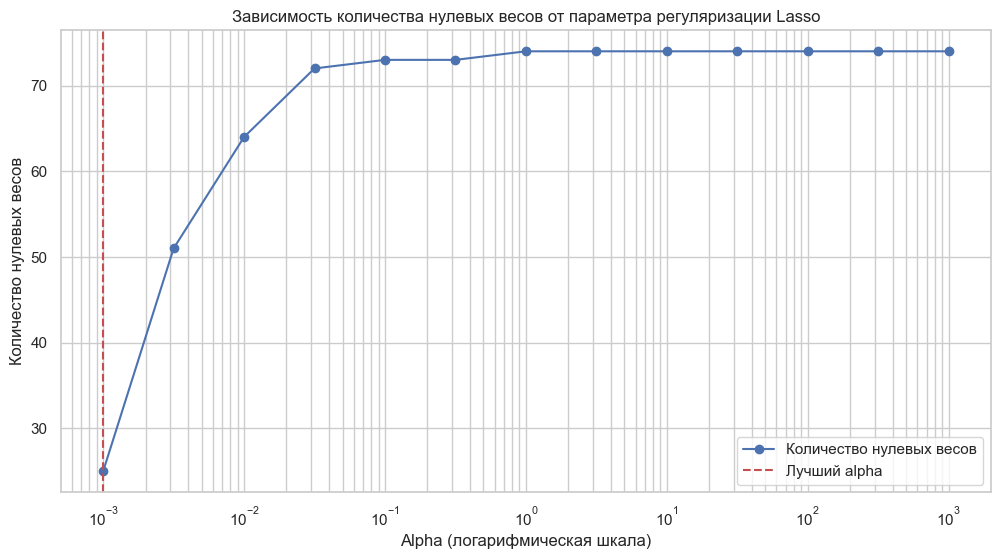


Для лучшей модели (alpha=0.0010):
Всего признаков: 74
Нулевых весов: 25 (33.8%)
Ненулевых весов: 49


In [189]:
alphas = lasso_grid.cv_results_['param_regressor__alpha'].data
zero_weights_counts = []

for params, mean_score in zip(lasso_grid.cv_results_['params'], 
                            lasso_grid.cv_results_['mean_test_score']):
    model = lasso_pipeline.set_params(**params).fit(X_train, y_train)
    weights = model.named_steps['regressor'].coef_
    zero_weights = np.sum(weights == 0)
    zero_weights_counts.append(zero_weights)
    print(f"Alpha: {params['regressor__alpha']:.5f} | "
          f"Нулевых весов: {zero_weights}/{len(weights)} | "
          f"RMSLE: {-mean_score:.4f}")

plt.figure(figsize=(12, 6))
plt.semilogx(alphas, zero_weights_counts, 'bo-', label='Количество нулевых весов')
plt.axvline(lasso_grid.best_params_['regressor__alpha'], 
            color='r', linestyle='--', label='Лучший alpha')
plt.xlabel('Alpha (логарифмическая шкала)')
plt.ylabel('Количество нулевых весов')
plt.title('Зависимость количества нулевых весов от параметра регуляризации Lasso')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()

best_lasso = lasso_grid.best_estimator_
best_weights = best_lasso.named_steps['regressor'].coef_
total_features = len(best_weights)
zero_features = np.sum(best_weights == 0)
print(f"\nДля лучшей модели (alpha={lasso_grid.best_params_['regressor__alpha']:.4f}):")
print(f"Всего признаков: {total_features}")
print(f"Нулевых весов: {zero_features} ({zero_features/total_features:.1%})")
print(f"Ненулевых весов: {total_features - zero_features}")


при занулении половины весов мы теряем в качестве не сильно.

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**.

Разумеется, погружаться в feature engineering можно ещё очень долго. Ваша задача - придумать какие-то новые признаки, которые сделают модель ещё лучше!! За улучшение функционала ошибки на каждые 0.005 на тестовой выборке относительно `best_rmsle` будет даваться 0.5 бонусных балла. Всего за этот пункт можно получить до 2 бонусных баллов.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Какие могут быть идеи для вдохновения:

1. Трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения, по аналогии с квадратной сеткой  
> Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.    

2. Мы пока что никак не использовали историчность и взаимосвязь в данных, хотя информация о том, что было ранее в эти/похожие дни тоже может пригодиться. Попробуйте поискать соседей и/или построить агрегации, например, при помощи groupby, посчитайте какие-либо статистики в пределах какого-то окна (подберите всё это сами, постарайтесь, чтобы это было что-то разумное), и присоедините к основному датафрейму
> Важно: учтите, что разных вариантов агрегаций и статистик существует очень много. Не стесняйтесь выкидывать фичи, которые вам не нравятся (помните про свойство Lasso), используйте эффективные способы хранения данных ([wink](https://www.kaggle.com/code/demche/polars-memory-usage-optimization)-[wink](https://docs.scipy.org/doc/scipy/reference/sparse.html))

3. В конце концов можно использовать альтернативные способы преобразования данных. Например, использовать другой scaler, другую кодировку категориальных фичей, другие гиперпараметры и пр. Но помните, что на данный момент мы ограничены только `Ridge` и `Lasso`

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ